### Parallel Gamma Generator

In [1]:
#The number of threads being used is set in the enviromental variables in Windows system (ask chatgpt for further details). 
#My computer has 8 CPU cores and 16 LUs, so 8 threads are used here.
using Base.Threads
println("Number of Threads:",nthreads())

Number of Threads:4


Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


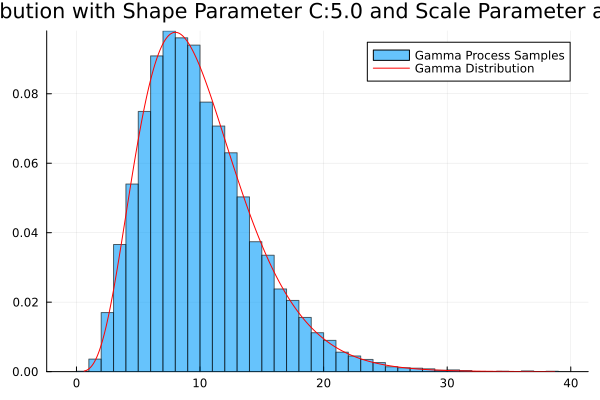

In [4]:
include("Julia_Implementation.jl")
using Random
import Pkg # Pkg is the package manager in Julia
using Distributions
using Plots
using LinearAlgebra
using ProgressMeter
N = 10000 # 样本数量
T = 1.0 # 模拟时间
beta = 0.5 # 逆比例参数
alpha = 1.0 / beta # 生成时的比例参数
C = 5.0 # 速率/形状参数
samples = Float64[]

@showprogress for i in 1:N
    samples_matrix, jump_time_matrix = Julia_Implementation.vectorized_particle_Gamma_generator(beta, C, T, 1, 500, 100)
    gamma_jumps = samples_matrix[1, :]
    gamma_jump_times = jump_time_matrix[1, :]
    sample = Julia_Implementation.integrate([1.0], gamma_jumps, gamma_jump_times)
    push!(samples, sample[1])
end

# 定义x的范围，以匹配samples的范围或更广
x = range(minimum(samples), stop=maximum(samples), length=1000)

p = histogram(samples, bins=50, normalize=true, alpha=0.6, label="Gamma Process Samples")
plot!(p, x, pdf.(Gamma(C, alpha), x), color=:red, label="Gamma Distribution")
title!(p, "Gamma Distribution with Shape Parameter C:$(C) and Scale Parameter alpha (1/beta):$(alpha)")
#legend!(:topright) # 如果需要图例，取消这行注释
display(p)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


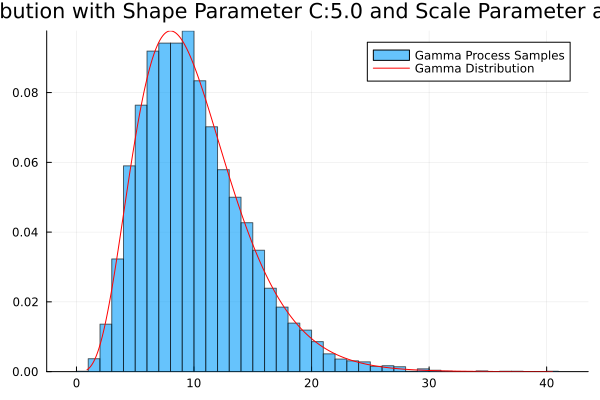

In [2]:
include("Julia_Implementation.jl")
using Random
import Pkg # Pkg is the package manager in Julia
using Distributions
using Plots
using LinearAlgebra
using ProgressMeter
N = 10000 # 样本数量
T = 1.0 # 模拟时间
beta = 0.5 # 逆比例参数
alpha = 1.0 / beta # 生成时的比例参数
C = 5.0 # 速率/形状参数
samples = Float64[]

@showprogress for i in 1:N
    samples_matrix, jump_time_matrix = Julia_Implementation.vectorized_particle_Gamma_generator(beta, C, T, 1, 500, true,100)
    gamma_jumps = samples_matrix[1, :]
    gamma_jump_times = jump_time_matrix[1, :]
    sample = Julia_Implementation.integrate([1.0], gamma_jumps, gamma_jump_times)
    push!(samples, sample[1])
end

# 定义x的范围，以匹配samples的范围或更广
x = range(minimum(samples), stop=maximum(samples), length=1000)

p = histogram(samples, bins=50, normalize=true, alpha=0.6, label="Gamma Process Samples")
plot!(p, x, pdf.(Gamma(C, alpha), x), color=:red, label="Gamma Distribution")
title!(p, "Gamma Distribution with Shape Parameter C:$(C) and Scale Parameter alpha (1/beta):$(alpha)")
#legend!(:topright) # 如果需要图例，取消这行注释
display(p)



### 3D Space Expoloration

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:45:32
Progress: 100%|█████████████████████████████████████████| Time: 1:00:54


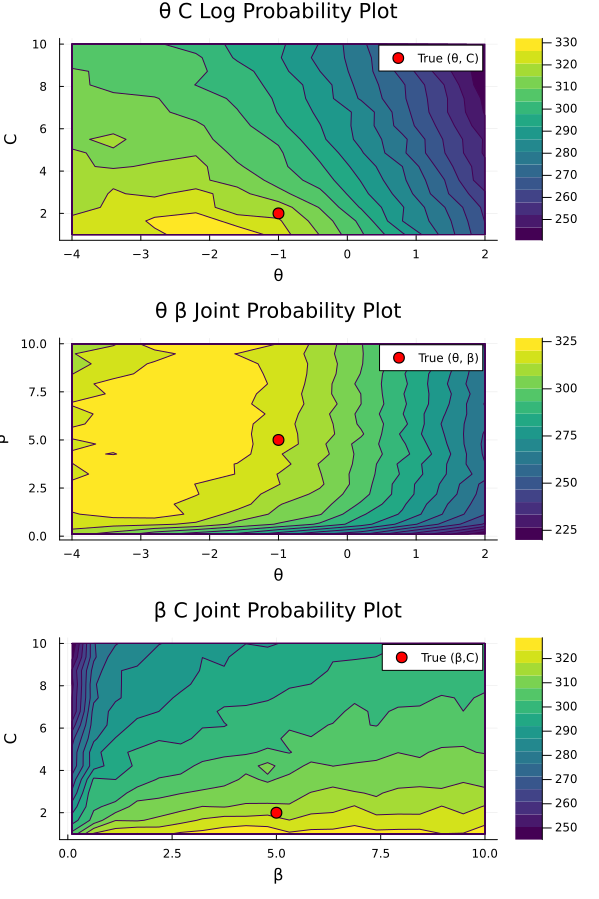

In [1]:

include("Julia_Implementation.jl")
using Random
using Distributions
using LinearAlgebra
using Statistics
using StatsFuns: logsumexp
using .Threads
using ProgressMeter
using SpecialFunctions
using Plots
using DataFrames
#Generating the noisy observations

num_particles = 5000

# 真实参数值
true_theta = -1.0
true_beta = 5.0
true_C = 2.0
#Searching range
theta_values = LinRange(-4.0, 2.0, 11)
beta_values = LinRange(0.1, 10.0, 20)
C_values = LinRange(1.0, 10.0, 15)

kw = 1.0
kv = 0.001
true_sigmaw2 = 0.2
true_sigmaw = sqrt(true_sigmaw2)
true_muw = 0.2
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
T = 30.0
N = 5*round(Int,T) # resolution

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta
h = [0.0 ; 1.0]
# 模拟
evaluation_points = range(0, T, length=N)
#print("Hi")

subordinator_jumps, jump_times = Julia_Implementation.vectorized_particle_Gamma_generator(true_beta, true_C, T, 1, 1, 10000)# subordinator jump sizes and times
SDE_samples = Julia_Implementation.generate_SDE_samples(subordinator_jumps[1,:],jump_times[1,:],true_muw,true_sigmaw,A,h,evaluation_points)
#print(size(samples))
Noisy_samples = SDE_samples[1, :] .+ randn(length(SDE_samples[1, :])) .* sigma_n




alphaw_prior = 2.1
betaw_prior = 1.0

# Pre-heating Run

warmup_log_probabilities = Julia_Implementation.Normal_Gamma_Langevin_Grid_Search(Noisy_samples,N,T,10,kw ,alphaw_prior,betaw_prior,kv, theta_values[1:3],beta_values[1:3], C_values[1:3])

fixed_beta_log_probabilities = Julia_Implementation.Normal_Gamma_Langevin_Grid_Search(Noisy_samples,N,T,num_particles,kw ,alphaw_prior,betaw_prior,kv, theta_values,[true_beta], C_values)
fixed_theta_log_probabilities = Julia_Implementation.Normal_Gamma_Langevin_Grid_Search(Noisy_samples,N,T,num_particles,kw ,alphaw_prior,betaw_prior,kv, [true_theta],beta_values, C_values)
fixed_C_log_probabilities = Julia_Implementation.Normal_Gamma_Langevin_Grid_Search(Noisy_samples,N,T,num_particles,kw ,alphaw_prior,betaw_prior,kv, theta_values,beta_values, [true_C])

fixed_beta_log_probabilities = fixed_beta_log_probabilities[:,1,:] #theta C
fixed_theta_log_probabilities = fixed_theta_log_probabilities[1,:,:] #beta C
fixed_C_log_probabilities = fixed_C_log_probabilities[:,:,1] #theta beta



# 绘制三个等高线图并将它们组合
p1 = contourf(theta_values, C_values, fixed_beta_log_probabilities',
              title="θ C Log Probability Plot",
              xlabel="θ", ylabel="C",
              color=:viridis)  # 使用viridis颜色图
scatter!(p1, [true_theta], [true_C], label="True (θ, C)", color=:red, markersize=6)  # 标记真实的θ和C值
p2 = contourf(theta_values, beta_values, fixed_C_log_probabilities',
              title="θ β Joint Probability Plot",
              xlabel="θ", ylabel="β",
              color=:viridis)  # 使用viridis颜色图
scatter!(p2, [true_theta], [true_beta], label="True (θ, β)", color=:red, markersize=6)  # 标记真实的θ和β值
p3 = contourf(beta_values, C_values, fixed_theta_log_probabilities',
              title="β C Joint Probability Plot",
              xlabel="β", ylabel="C",
              color=:viridis)  # 使用viridis颜色图
scatter!(p3, [true_beta], [true_C], label="True (β,C)", color=:red, markersize=6)  # 标记真实的C和β值
# 将三个图放在一个布局里面
plot(p1, p2, p3, layout=(3, 1), size=(600, 900))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:44:36
Progress: 100%|█████████████████████████████████████████| Time: 1:02:58


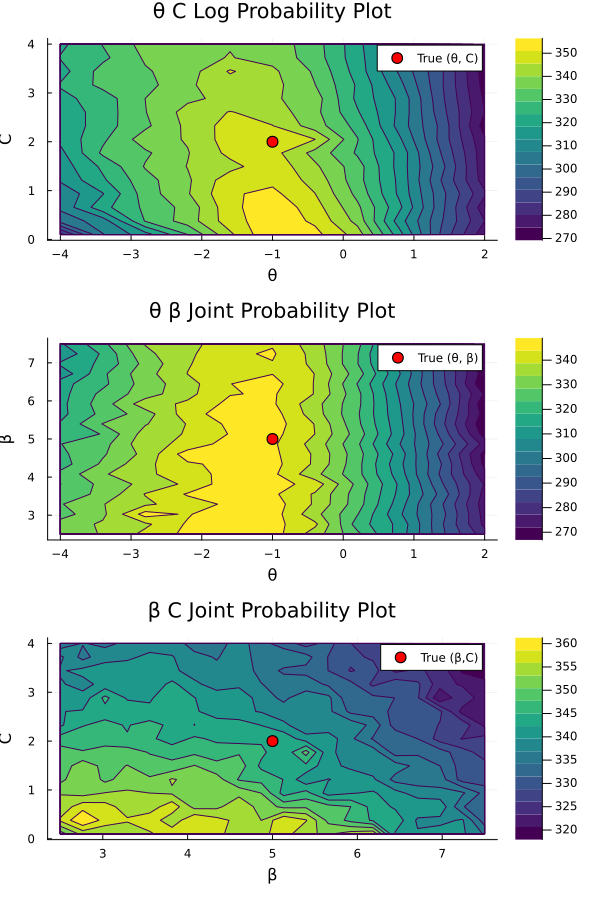

In [1]:

include("Julia_Implementation.jl")
using Random
using Distributions
using LinearAlgebra
using Statistics
using StatsFuns: logsumexp
using .Threads
using ProgressMeter
using SpecialFunctions
using Plots
using DataFrames
#Generating the noisy observations

num_particles = 5000

# 真实参数值
true_theta = -1.0
true_beta = 5.0
true_C = 2.0
#Searching range
theta_values = LinRange(-4.0, 2.0, 11)
beta_values = LinRange(2.5, 7.5, 20)
C_values = LinRange(0.1, 4.0, 15)

kw = 1.0
kv = 0.001
true_sigmaw2 = 0.2
true_sigmaw = sqrt(true_sigmaw2)
true_muw = 0.2
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
T = 30.0
N = 5*round(Int,T) # resolution

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta
h = [0.0 ; 1.0]
# 模拟
evaluation_points = range(0, T, length=N)
#print("Hi")

subordinator_jumps, jump_times = Julia_Implementation.vectorized_particle_Gamma_generator(true_beta, true_C, T, 1, 1, 10000)# subordinator jump sizes and times
SDE_samples = Julia_Implementation.generate_SDE_samples(subordinator_jumps[1,:],jump_times[1,:],true_muw,true_sigmaw,A,h,evaluation_points)
#print(size(samples))
Noisy_samples = SDE_samples[1, :] .+ randn(length(SDE_samples[1, :])) .* sigma_n




alphaw_prior = 2.1
betaw_prior = 1.0

# Pre-heating Run

warmup_log_probabilities = Julia_Implementation.Normal_Gamma_Langevin_Grid_Search(Noisy_samples,N,T,10,kw ,alphaw_prior,betaw_prior,kv, theta_values[1:3],beta_values[1:3], C_values[1:3])

fixed_beta_log_probabilities = Julia_Implementation.Normal_Gamma_Langevin_Grid_Search(Noisy_samples,N,T,num_particles,kw ,alphaw_prior,betaw_prior,kv, theta_values,[true_beta], C_values)
fixed_theta_log_probabilities = Julia_Implementation.Normal_Gamma_Langevin_Grid_Search(Noisy_samples,N,T,num_particles,kw ,alphaw_prior,betaw_prior,kv, [true_theta],beta_values, C_values)
fixed_C_log_probabilities = Julia_Implementation.Normal_Gamma_Langevin_Grid_Search(Noisy_samples,N,T,num_particles,kw ,alphaw_prior,betaw_prior,kv, theta_values,beta_values, [true_C])

fixed_beta_log_probabilities = fixed_beta_log_probabilities[:,1,:] #theta C
fixed_theta_log_probabilities = fixed_theta_log_probabilities[1,:,:] #beta C
fixed_C_log_probabilities = fixed_C_log_probabilities[:,:,1] #theta beta



# 绘制三个等高线图并将它们组合
p1 = contourf(theta_values, C_values, fixed_beta_log_probabilities',
              title="θ C Log Probability Plot",
              xlabel="θ", ylabel="C",
              color=:viridis)  # 使用viridis颜色图
scatter!(p1, [true_theta], [true_C], label="True (θ, C)", color=:red, markersize=6)  # 标记真实的θ和C值
p2 = contourf(theta_values, beta_values, fixed_C_log_probabilities',
              title="θ β Joint Probability Plot",
              xlabel="θ", ylabel="β",
              color=:viridis)  # 使用viridis颜色图
scatter!(p2, [true_theta], [true_beta], label="True (θ, β)", color=:red, markersize=6)  # 标记真实的θ和β值
p3 = contourf(beta_values, C_values, fixed_theta_log_probabilities',
              title="β C Joint Probability Plot",
              xlabel="β", ylabel="C",
              color=:viridis)  # 使用viridis颜色图
scatter!(p3, [true_beta], [true_C], label="True (β,C)", color=:red, markersize=6)  # 标记真实的C和β值
# 将三个图放在一个布局里面
plot(p1, p2, p3, layout=(3, 1), size=(600, 900))

Progress: 100%|█████████████████████████████████████████| Time: 18:25:23


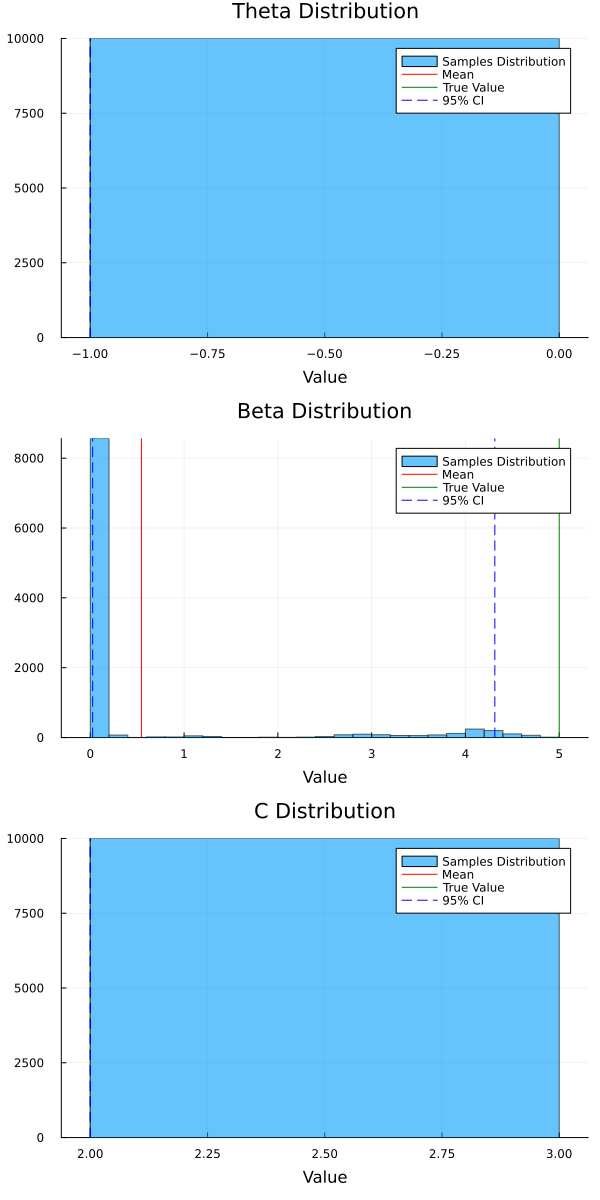

In [1]:

include("Julia_Implementation.jl")
using Random
using Distributions
using LinearAlgebra
using Statistics
using StatsFuns: logsumexp
using .Threads
using ProgressMeter
using SpecialFunctions
using Plots
using DataFrames
#Generating the noisy observations

# 参数初始化
num_iter = 10000 # 迭代次数
num_particles = 2000


# 三个参数的步长
l_theta = 0.0
l_beta = 0.1
l_C = 0.0
# 参数priors
theta0 = -1.0 # theta的初始猜测
beta0 = 3.0 # beta的初始猜测
C0 = 2.0 # C的初始猜测

# 真实参数值
true_theta = -1.0
true_beta = 5.0
true_C = 2.0


kw = 1.0
kv = 0.001
true_sigmaw2 = 0.2
true_sigmaw = sqrt(true_sigmaw2)
true_muw = 0.2
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
T = 30.0
N = 5*round(Int,T) # resolution

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta
h = [0.0 ; 1.0]
# 模拟
evaluation_points = range(0, T, length=N)
#print("Hi")

subordinator_jumps, jump_times = Julia_Implementation.vectorized_particle_Gamma_generator(true_beta, true_C, T, 1, 1, 10000)# subordinator jump sizes and times
SDE_samples = Julia_Implementation.generate_SDE_samples(subordinator_jumps[1,:],jump_times[1,:],true_muw,true_sigmaw,A,h,evaluation_points)
#print(size(samples))
Noisy_samples = SDE_samples[1, :] .+ randn(length(SDE_samples[1, :])) .* sigma_n




alphaw_prior = 2.1
betaw_prior = 1.0

# Pre-heating Run
Julia_Implementation.Normal_Gamma_Langevin_GRW_MCMC_double_update(Noisy_samples,N,T,10,10,kw ,alphaw_prior,betaw_prior,kv, theta0, beta0, C0, l_theta,l_beta,l_C)


#Serious Run
theta_samples, beta_samples, C_samples,acceptance_log_probabilities = Julia_Implementation.Normal_Gamma_Langevin_GRW_MCMC_double_update(Noisy_samples,N,T,num_particles,num_iter,kw ,alphaw_prior,betaw_prior,kv, theta0, beta0, C0, l_theta,l_beta,l_C,rejection_limit = 5)


p1 = Julia_Implementation.plot_samples_distribution(theta_samples, true_theta, "Theta Distribution")
p2 = Julia_Implementation.plot_samples_distribution(beta_samples, true_beta, "Beta Distribution")
p3 = Julia_Implementation.plot_samples_distribution(C_samples, true_C, "C Distribution")

# Combine the plots
plot(p1, p2, p3, layout=(3, 1), size=(600, 1200))


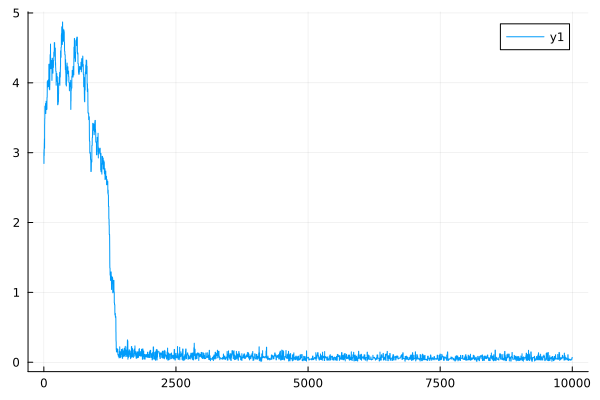

In [2]:
plot(beta_samples)